In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from committee_learning.ode import SphericalSquaredActivationODE
from committee_learning.initial_conditions import SymmetricInitialConditions
from committee_learning.simulation import NormalizedSphericalConstraintSimulation
from committee_learning.result import SquareODEResult, SimulationResult
import numpy as np
from tqdm import tqdm

d = 10000
p = 1
k = 1
alpha = 0.1
noise = 0.#1e-3
dt = 1e-4
log_time = 2
id_n = 112
m_threshold = 0.1

# The goal is to fix always the same initial conditions and then do many runs to see what happens
ic = SymmetricInitialConditions(p = p, k = k, epsilon=0., q0=1., seed = 0)
Wteacher, W0 = ic.weights(d)
print(ic.Q,ic.P,ic.M)
print(sum(Wteacher[0]*Wteacher[0]))

[[1.]] [[1.]] [[0.]]
10000.000000000007


In [ ]:
def 

### Simulations

In [51]:
sim_times = []
sim_risks = []
sim_Ms = []
for id in tqdm(range(id_n)):
  sim = NormalizedSphericalConstraintSimulation(d,p,k,noise,Wteacher,alpha*p,'square',W0)
  # print(f'Simulating id = {id}')
  simr = SimulationResult(initial_condition='spherical-sde-test-browninian-orthogonal', id=id)
  simr.from_file_or_run(sim,2+np.log10(sim.d),path='computation-database/sim/',force_read=True)
  if id == 0:
    sim_times = np.array(simr.steps)/d
  sim_risks.append(simr.macroscopic_risk())
  sim_Ms.append(simr.Ms)

sim_risks = np.array(sim_risks)
sim_Ms = np.array(sim_Ms,).reshape((sim_risks.shape))

100%|██████████| 112/112 [00:32<00:00,  3.48it/s]


### ODE

In [59]:
ode = SphericalSquaredActivationODE(p,k,noise,alpha*p,ic.P,ic.Q,ic.M,dt)
oder = SquareODEResult(initial_condition='spherical-phase-retrivial-ode-orthogonal', id=0)
oder.from_file_or_run(ode, log_time, path='computation-database/ode/')

ode_times = np.array(oder.times)
ode_Ms = np.array(oder.Ms).reshape(ode_times.shape)

### SDE

In [53]:
from committee_learning.sde.phase_retrivial import SphericalPhaseRetrivialSDE

sde_times = []
sde_risks = []
sde_Ms = []
for id in tqdm(range(id_n)):
  sde = SphericalPhaseRetrivialSDE(noise, alpha*p, ic.P, ic.Q, ic.M, d, dt, seed=id)
  sder = SquareODEResult(initial_condition='spherical-phase-retrivial-sde-orthogonal', id=id)
  sder.from_file_or_run(sde, log_time, path='computation-database/sde/')
  if id == 0:
    sde_times = np.array(sder.times)
  sde_risks.append(sder.risks)
  sde_Ms.append(sder.Ms)

sde_risks = np.array(sde_risks)
sde_Ms = np.array(sde_Ms).reshape((sde_risks.shape))


100%|██████████| 112/112 [00:30<00:00,  3.69it/s]


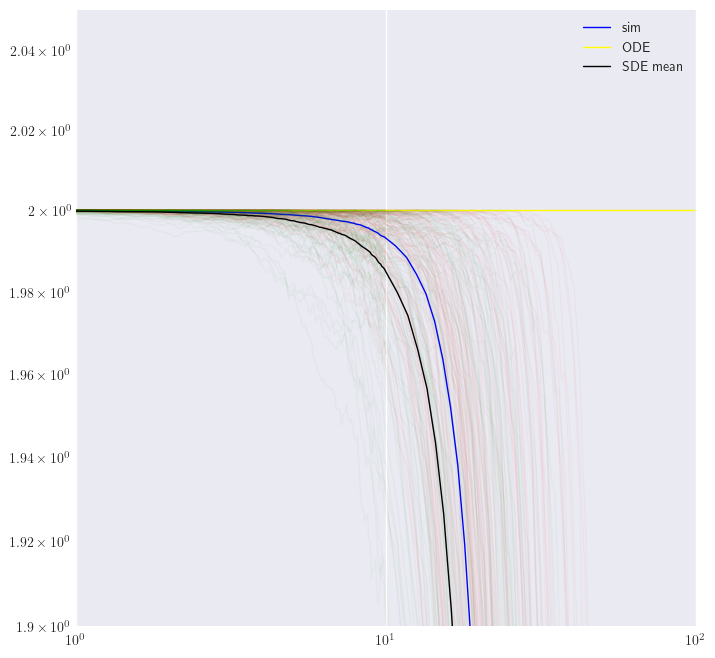

In [54]:
from committee_learning.utilities import plot_style
import matplotlib.pyplot as plt

with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlim(1,100)
  ax.set_ylim(1.9,2.05)
  ax.plot(sim_times, sim_risks.T,ls='-',lw=1.,marker='',ms=5.,c='red',alpha=0.0325)
  ax.plot(sim_times, np.mean(sim_risks, axis = 0), label =f'sim', ls='-',lw=1.,marker='',ms=2.,c='blue')

  ax.plot(oder.times, oder.risks, label = 'ODE', ls='-',lw=1.,marker='',ms=2.,c='yellow')

  ax.plot(sde_times, sde_risks.T, ls='-',lw=1.,marker='',ms=2.,c='green', alpha=0.0325)
  ax.plot(sde_times, np.mean(sde_risks, axis = 0), label =f'SDE mean', ls='-',lw=1.,marker='',ms=2.,c='black')
  ax.legend()
  plt.show()

**Probably there is so much noise after the drop because we are entering in what Ben Arus calls "balistic phase", and the Brownian motion it's not there anymore.**

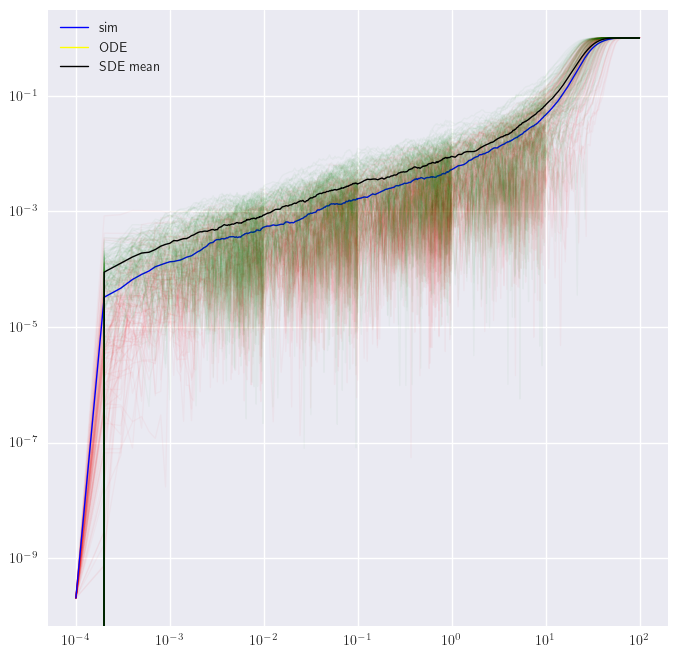

In [69]:
with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xscale('log')
  ax.set_yscale('log')
  # ax.set_xlim(1,100)
  # ax.set_ylim(1e-5,1.05)
  ax.plot(sim_times, abs(sim_Ms.T),ls='-',lw=1.,marker='',ms=5.,c='red',alpha=0.0325)
  ax.plot(sim_times, np.mean(abs(sim_Ms), axis = 0), label =f'sim', ls='-',lw=1.,marker='',ms=2.,c='blue')

  ax.plot(ode_times, ode_Ms, label = 'ODE', ls='-',lw=1.,marker='',ms=2.,c='yellow')

  ax.plot(sde_times, abs(sde_Ms).T, ls='-',lw=1.,marker='',ms=2.,c='green', alpha=0.0325)
  ax.plot(sde_times, np.mean(abs(sde_Ms), axis = 0), label =f'SDE mean', ls='-',lw=1.,marker='',ms=2.,c='black')
  ax.legend()
  plt.show()